In [1]:
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

# Load Dataset

In [3]:
df = pd.read_csv('adult_health_based_on_childhood.csv', encoding='latin1')
df.head()

,Sl. No.,Age,Gender,Childhood_Location_type,playing_hr,Sports_physical_activities,using_vehicle,house_help,bed_time,fixed_bed_time,...,experience_bulling,parental_interection,Missed_school,Experienced_trauma,poor_posture,digital_device_before_12,ADHD,Depression,Sleep Disorder,Postural Issues
0,1,23,Female,Urban,<30 min,Never,School transport,Yes,After 10 PM,Sometimes,...,No,Sometimes,Yes,Yes,Never,No,0,0,0,0
1,2,24,Male,Rural,30 min - 1 hr,Occasionally,Walk/Bicycle,Occasionally,9 - 10 PM,Sometimes,...,Yes,Sometimes,Yes,No,Never,No,0,0,1,0
2,3,24,Female,Urban,> 2 hr,Occasionally,Personal vehicle,Yes,After 10 PM,Sometimes,...,Yes,Yes,Yes,Yes,Sometimes,No,0,0,0,0
3,4,27,Male,Urban,> 2 hr,Regularly,School transport,No,After 10 PM,Always,...,No,Yes,No,No,Never,Yes,1,1,0,1
4,5,25,Male,Urban,> 2 hr,Regularly,Walk/Bicycle,Yes,After 10 PM,Sometimes,...,No,Yes,Yes,No,Often,No,1,1,1,0


# 1. EDA- Exploratory Data Analysis

> Dataset Summary

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Sl. No.                         506 non-null    int64 
 1    Age                            506 non-null    int64 
 2   Gender                          506 non-null    object
 3   Childhood_Location_type         506 non-null    object
 4   playing_hr                      506 non-null    object
 5   Sports_physical_activities      506 non-null    object
 6   using_vehicle                   506 non-null    object
 7   house_help                      506 non-null    object
 8   bed_time                        506 non-null    object
 9   fixed_bed_time                  506 non-null    object
 10  sleeping_trouble                506 non-null    object
 11  tv/computer_availablity         506 non-null    object
 12  screen_time                     506 non-null    ob

,Sl. No.,Age,ADHD,Depression,Sleep Disorder,Postural Issues
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,253.500000,27.300395,0.250988,0.296443,0.322134,0.353755
std,146.213884,6.026072,0.434011,0.457140,0.467757,0.478607
min,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000
25%,127.250000,22.250000,0.000000,0.000000,0.000000,0.000000
50%,253.500000,26.000000,0.000000,0.000000,0.000000,0.000000
75%,379.750000,32.000000,0.750000,1.000000,1.000000,1.000000
max,506.000000,39.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())


Shape: (506, 25)

Data Types:
 Sl. No.                            int64
 Age                               int64
Gender                            object
Childhood_Location_type           object
playing_hr                        object
Sports_physical_activities        object
using_vehicle                     object
house_help                        object
bed_time                          object
fixed_bed_time                    object
sleeping_trouble                  object
tv/computer_availablity           object
screen_time                       object
content_type                      object
inattentive_impulsive_restless    object
experience_bulling                object
parental_interection              object
Missed_school                     object
Experienced_trauma                object
poor_posture                      object
digital_device_before_12          object
ADHD                               int64
Depression                         int64
Sleep Disorder            

> Distribution of Features

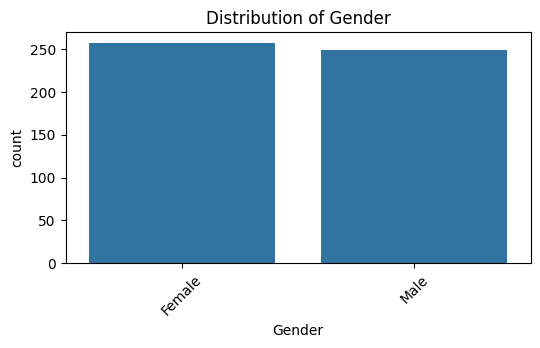

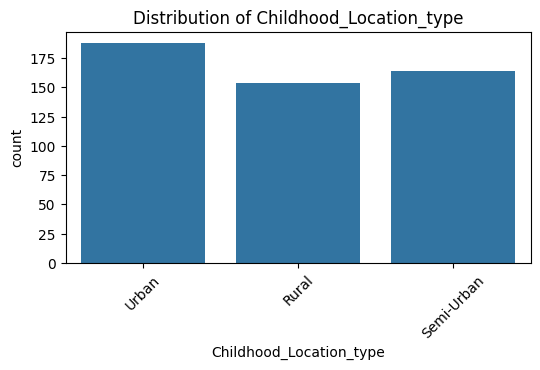

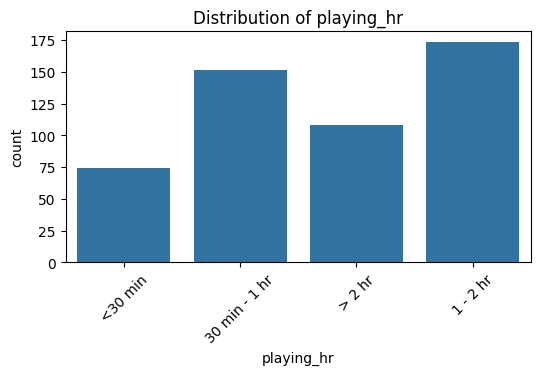

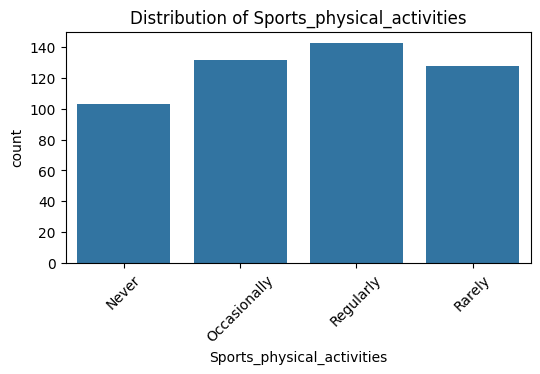

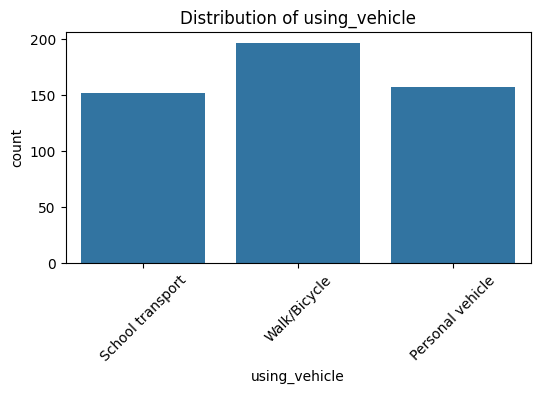

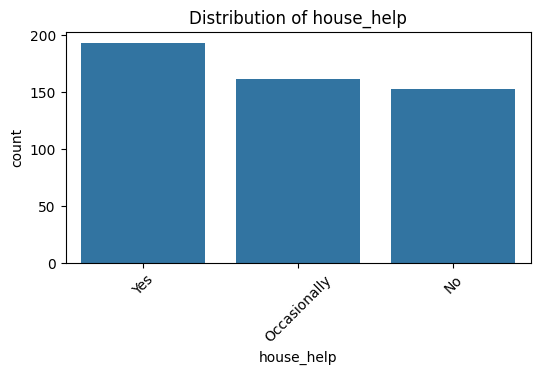

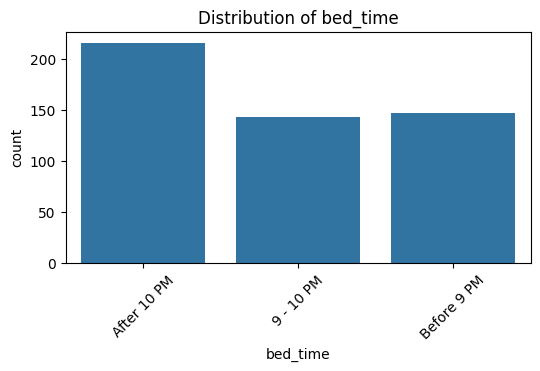

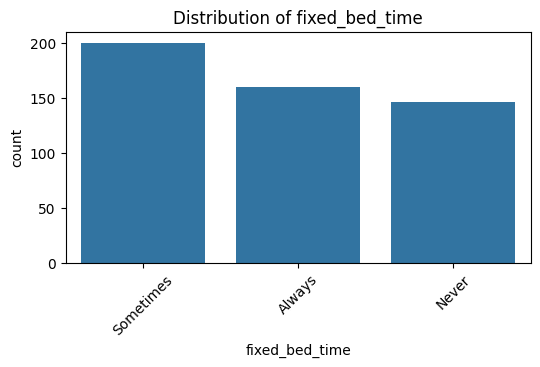

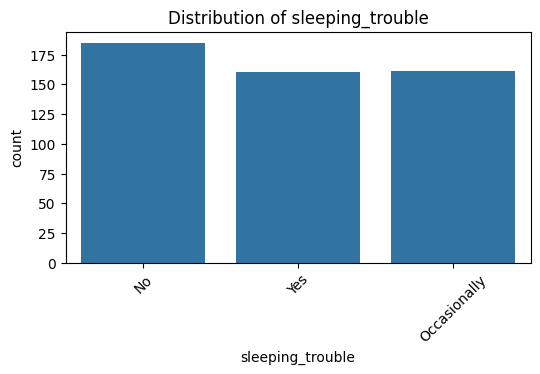

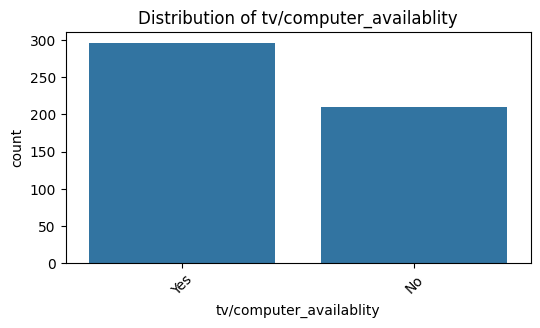

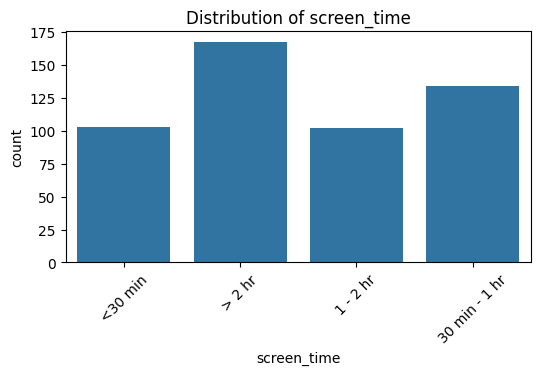

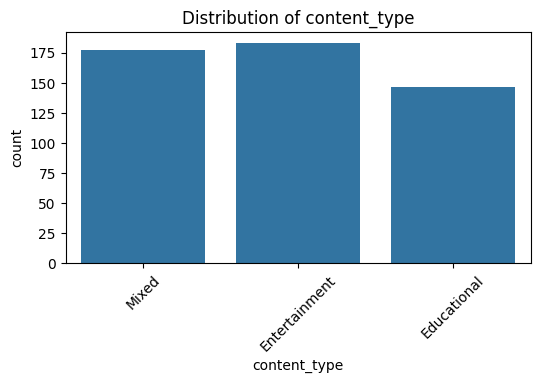

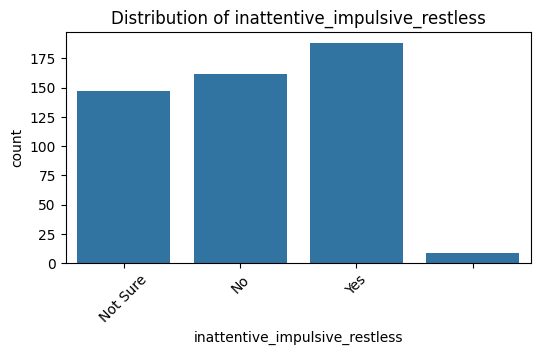

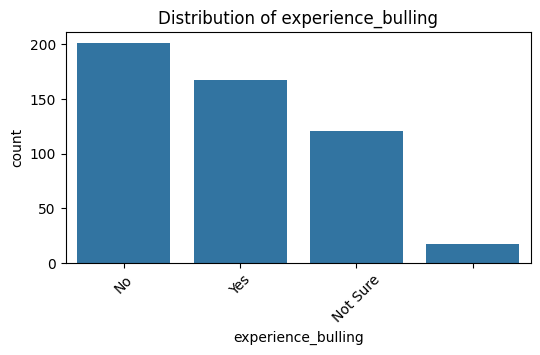

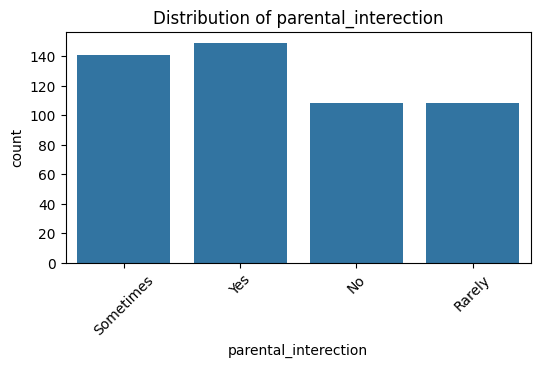

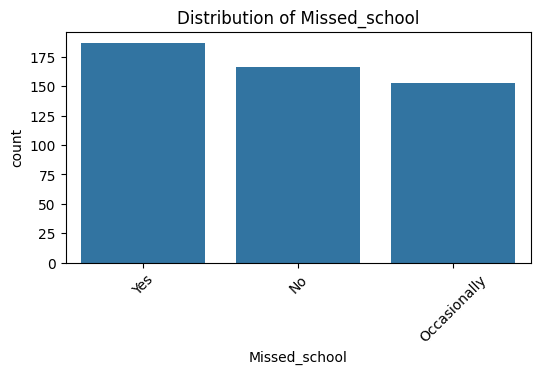

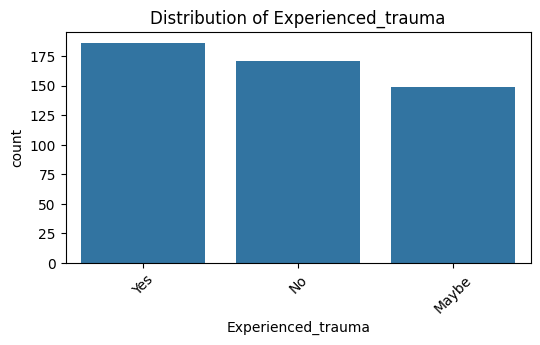

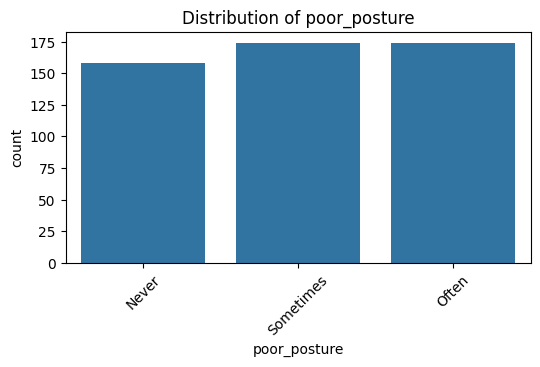

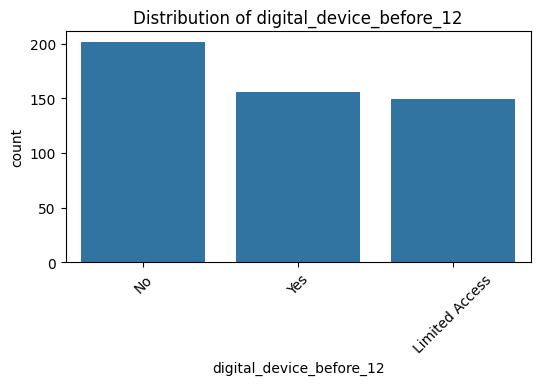

In [6]:
cat_features = df.select_dtypes(include='object').columns
for col in cat_features:
    plt.figure(figsize=(6,3))
    sns.countplot(data=df, x=col)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')
    plt.show()


> Correlation Heatmap (Targets)

<Axes: xlabel=' Age', ylabel='count'>

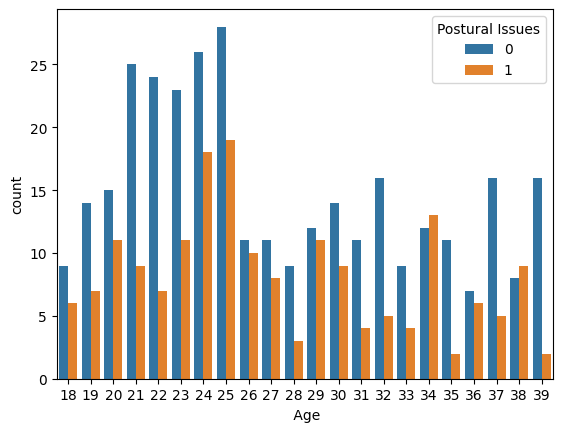

In [7]:
sns.countplot(x=' Age',hue='Postural Issues',data=df)

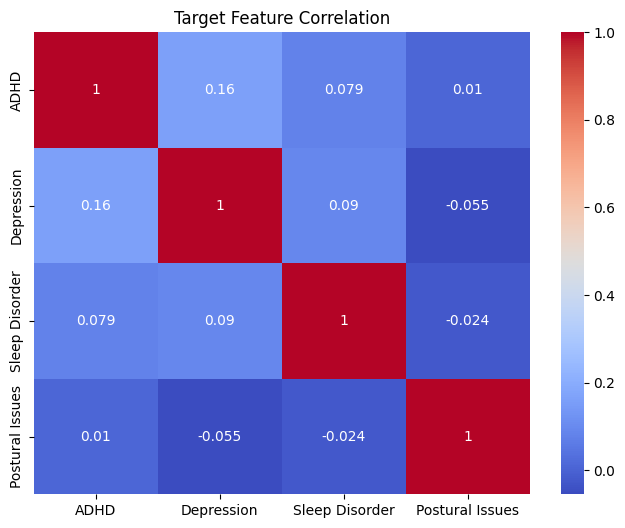

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['ADHD','Depression','Sleep Disorder','Postural Issues']].corr(), annot=True, cmap='coolwarm')
plt.title('Target Feature Correlation')
plt.show()

# 2. Feature Engineering

>  Convert time strings to ordinal values

In [9]:
time_map = {'< 30 min': 0, '30 min - 1 hr': 1, '1–2 hr': 2, '> 2 hr': 3, '1-2 hr': 2}
df['playing_hr'] = df['playing_hr'].map(time_map)
df['screen_time'] = df['screen_time'].map(time_map)

> New feature: total risk score

In [10]:
df['risk_score'] = df['playing_hr'] + df['screen_time']

df.head()

,Sl. No.,Age,Gender,Childhood_Location_type,playing_hr,Sports_physical_activities,using_vehicle,house_help,bed_time,fixed_bed_time,...,parental_interection,Missed_school,Experienced_trauma,poor_posture,digital_device_before_12,ADHD,Depression,Sleep Disorder,Postural Issues,risk_score
0,1,23,Female,Urban,NaN,Never,School transport,Yes,After 10 PM,Sometimes,...,Sometimes,Yes,Yes,Never,No,0,0,0,0,NaN
1,2,24,Male,Rural,1.0,Occasionally,Walk/Bicycle,Occasionally,9 - 10 PM,Sometimes,...,Sometimes,Yes,No,Never,No,0,0,1,0,4.0
2,3,24,Female,Urban,3.0,Occasionally,Personal vehicle,Yes,After 10 PM,Sometimes,...,Yes,Yes,Yes,Sometimes,No,0,0,0,0,6.0
3,4,27,Male,Urban,3.0,Regularly,School transport,No,After 10 PM,Always,...,Yes,No,No,Never,Yes,1,1,0,1,6.0
4,5,25,Male,Urban,3.0,Regularly,Walk/Bicycle,Yes,After 10 PM,Sometimes,...,Yes,Yes,No,Often,No,1,1,1,0,6.0


# 3. Data Preprocessing

In [11]:
print(df.columns.tolist())


['Sl. No.', ' Age', 'Gender', 'Childhood_Location_type', 'playing_hr', 'Sports_physical_activities', 'using_vehicle', 'house_help', 'bed_time', 'fixed_bed_time', 'sleeping_trouble', 'tv/computer_availablity', 'screen_time', 'content_type', 'inattentive_impulsive_restless', 'experience_bulling', 'parental_interection', 'Missed_school', 'Experienced_trauma', 'poor_posture', 'digital_device_before_12', 'ADHD', 'Depression', 'Sleep Disorder', 'Postural Issues', 'risk_score']


> Check Missing value

In [12]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Sl. No.                             0
 Age                                0
Gender                              0
Childhood_Location_type             0
playing_hr                        247
Sports_physical_activities          0
using_vehicle                       0
house_help                          0
bed_time                            0
fixed_bed_time                      0
sleeping_trouble                    0
tv/computer_availablity             0
screen_time                       205
content_type                        0
inattentive_impulsive_restless      0
experience_bulling                  0
parental_interection                0
Missed_school                       0
Experienced_trauma                  0
poor_posture                        0
digital_device_before_12            0
ADHD                                0
Depression                          0
Sleep Disorder                      0
Postural Issues                     0
risk_score                      

In [13]:
# Drop irrelevant columns
# df.drop(['Sl. No.'], axis=1, inplace=True)

# Fill missing values
df['playing_hr'] = df['playing_hr'].fillna(df['playing_hr'].mode()[0])
df['screen_time'] = df['screen_time'].fillna(df['screen_time'].mode()[0])
df['risk_score'] = df['risk_score'].fillna(df['risk_score'].mean())

# Encode categorical features
cat_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Scale numeric features
scaler = StandardScaler()
df[[' Age']] = scaler.fit_transform(df[[' Age']])

df.head()


,Sl. No.,Age,playing_hr,screen_time,ADHD,Depression,Sleep Disorder,Postural Issues,risk_score,Gender_Male,...,parental_interection_Sometimes,parental_interection_Yes,Missed_school_Occasionally,Missed_school_Yes,Experienced_trauma_No,Experienced_trauma_Yes,poor_posture_Often,poor_posture_Sometimes,digital_device_before_12_No,digital_device_before_12_Yes
0,1,-0.714338,1.0,3.0,0,0,0,0,4.0,0,...,1,0,0,1,0,1,0,0,1,0
1,2,-0.548228,1.0,3.0,0,0,1,0,4.0,1,...,1,0,0,1,1,0,0,0,1,0
2,3,-0.548228,3.0,3.0,0,0,0,0,6.0,0,...,0,1,0,1,0,1,0,1,1,0
3,4,-0.049899,3.0,3.0,1,1,0,1,6.0,1,...,0,1,0,0,1,0,0,0,0,1
4,5,-0.382118,3.0,3.0,1,1,1,0,6.0,1,...,0,1,0,1,1,0,1,0,1,0


In [14]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Sl. No.                                    0
 Age                                       0
playing_hr                                 0
screen_time                                0
ADHD                                       0
Depression                                 0
Sleep Disorder                             0
Postural Issues                            0
risk_score                                 0
Gender_Male                                0
Childhood_Location_type_Semi-Urban         0
Childhood_Location_type_Urban              0
Sports_physical_activities_Occasionally    0
Sports_physical_activities_Rarely          0
Sports_physical_activities_Regularly       0
using_vehicle_School transport             0
using_vehicle_Walk/Bicycle                 0
house_help_Occasionally                    0
house_help_Yes                             0
bed_time_After 10 PM                       0
bed_time_Before 9 PM                       0
fixed_bed_time_Never                 

In [15]:
from sklearn.preprocessing import LabelEncoder
for column in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
df.head()

,Sl. No.,Age,playing_hr,screen_time,ADHD,Depression,Sleep Disorder,Postural Issues,risk_score,Gender_Male,...,parental_interection_Sometimes,parental_interection_Yes,Missed_school_Occasionally,Missed_school_Yes,Experienced_trauma_No,Experienced_trauma_Yes,poor_posture_Often,poor_posture_Sometimes,digital_device_before_12_No,digital_device_before_12_Yes
0,1,-0.714338,1.0,3.0,0,0,0,0,4.0,0,...,1,0,0,1,0,1,0,0,1,0
1,2,-0.548228,1.0,3.0,0,0,1,0,4.0,1,...,1,0,0,1,1,0,0,0,1,0
2,3,-0.548228,3.0,3.0,0,0,0,0,6.0,0,...,0,1,0,1,0,1,0,1,1,0
3,4,-0.049899,3.0,3.0,1,1,0,1,6.0,1,...,0,1,0,0,1,0,0,0,0,1
4,5,-0.382118,3.0,3.0,1,1,1,0,6.0,1,...,0,1,0,1,1,0,1,0,1,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 45 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Sl. No.                                  506 non-null    int64  
 1    Age                                     506 non-null    float64
 2   playing_hr                               506 non-null    float64
 3   screen_time                              506 non-null    float64
 4   ADHD                                     506 non-null    int64  
 5   Depression                               506 non-null    int64  
 6   Sleep Disorder                           506 non-null    int64  
 7   Postural Issues                          506 non-null    int64  
 8   risk_score                               506 non-null    float64
 9   Gender_Male                              506 non-null    uint8  
 10  Childhood_Location_type_Semi-Urban       506 non-n

# 4. Model Training - KNN, RandomForest,SVM

> Features and target separetion

In [17]:
X = df.drop(['Sl. No.','ADHD','Depression','Sleep Disorder','Postural Issues'], axis=1)
y = df[['ADHD','Depression','Sleep Disorder','Postural Issues']]

> Train test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


> Impute missing values in train and test of X

In [19]:
# from sklearn.impute import SimpleImputer

# Impute missing values in X_train and X_test
# imputer = SimpleImputer(strategy='mean')  # or use 'median' or 'most_frequent'
# X_train = imputer.fit_transform(X_train)
# X_test = imputer.transform(X_test)


> PCA as a feature engineering

In [20]:
# Standardize the features first (PCA is sensitive to scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)  # Let PCA decide the number of components
X_pca = pca.fit_transform(X_scaled)

# Explained Variance Plot
plt.figure(figsize=(10,6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

> ADHD-PCA

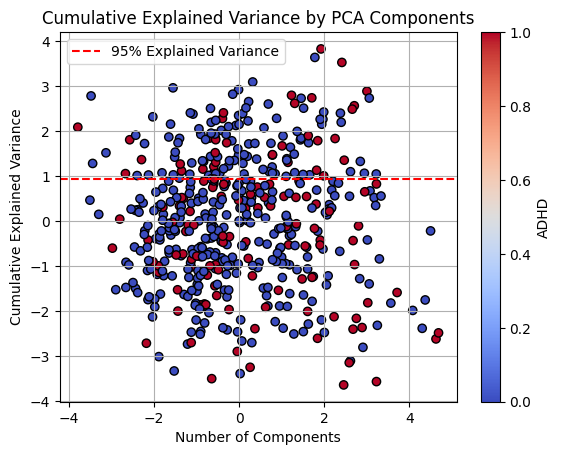

Original feature count: 40
Reduced feature count after PCA: 32


In [21]:

#plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['ADHD'], cmap='coolwarm', edgecolor='k')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.colorbar(label="ADHD")
plt.legend()
plt.show()

# Optional: Reduce to top k components (e.g., 10 or 95% variance)
pca_k = PCA(n_components=0.95)  # Keep 95% of variance
X_pca_reduced = pca_k.fit_transform(X_scaled)

print(f"Original feature count: {X.shape[1]}")
print(f"Reduced feature count after PCA: {X_pca_reduced.shape[1]}")


> Depression- PCA

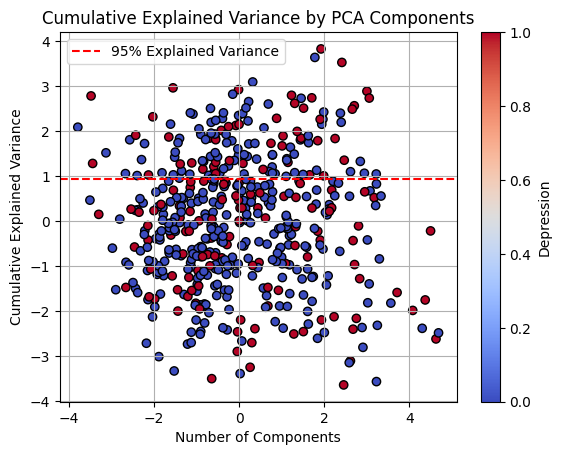

Original feature count: 40
Reduced feature count after PCA: 32


In [22]:
#plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Depression'], cmap='coolwarm', edgecolor='k')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.colorbar(label="Depression")
plt.legend()
plt.show()

# Optional: Reduce to top k components (e.g., 10 or 95% variance)
pca_k = PCA(n_components=0.95)  # Keep 95% of variance
X_pca_reduced = pca_k.fit_transform(X_scaled)

print(f"Original feature count: {X.shape[1]}")
print(f"Reduced feature count after PCA: {X_pca_reduced.shape[1]}")

> Sleep Disorder - PCA

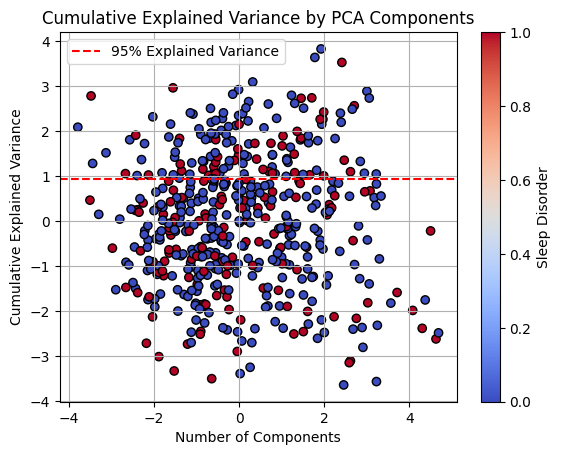

Original feature count: 40
Reduced feature count after PCA: 32


In [23]:
#plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Sleep Disorder'], cmap='coolwarm', edgecolor='k')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.colorbar(label="Sleep Disorder")
plt.legend()
plt.show()

# Optional: Reduce to top k components (e.g., 10 or 95% variance)
pca_k = PCA(n_components=0.95)  # Keep 95% of variance
X_pca_reduced = pca_k.fit_transform(X_scaled)

print(f"Original feature count: {X.shape[1]}")
print(f"Reduced feature count after PCA: {X_pca_reduced.shape[1]}")

> Postural Issues - PCA

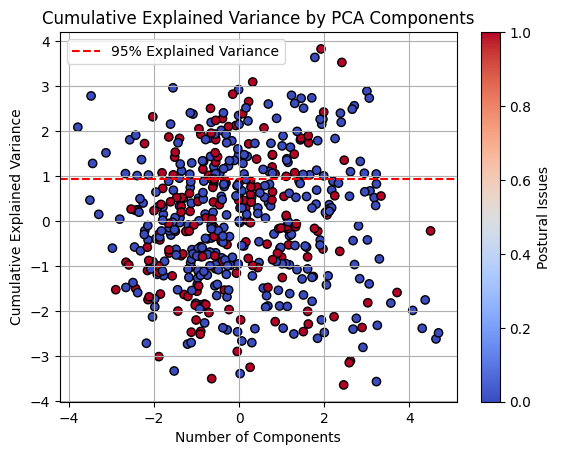

Original feature count: 40
Reduced feature count after PCA: 32


In [24]:
#plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Postural Issues'], cmap='coolwarm', edgecolor='k')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.colorbar(label="Postural Issues")
plt.legend()
plt.show()

# Optional: Reduce to top k components (e.g., 10 or 95% variance)
pca_k = PCA(n_components=0.95)  # Keep 95% of variance
X_pca_reduced = pca_k.fit_transform(X_scaled)

print(f"Original feature count: {X.shape[1]}")
print(f"Reduced feature count after PCA: {X_pca_reduced.shape[1]}")

> Initialize models

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 45 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Sl. No.                                  506 non-null    int64  
 1    Age                                     506 non-null    float64
 2   playing_hr                               506 non-null    float64
 3   screen_time                              506 non-null    float64
 4   ADHD                                     506 non-null    int64  
 5   Depression                               506 non-null    int64  
 6   Sleep Disorder                           506 non-null    int64  
 7   Postural Issues                          506 non-null    int64  
 8   risk_score                               506 non-null    float64
 9   Gender_Male                              506 non-null    uint8  
 10  Childhood_Location_type_Semi-Urban       506 non-n

In [26]:
# ✅ Define an extended set of models
models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Store results
results = {}

# Evaluate each model on each target condition
for label in y.columns:
    print(f"\n🔍 Predicting: {label}")
    for name, model in models.items():
        model.fit(X_train, y_train[label])
        preds = model.predict(X_test)
        acc = accuracy_score(y_test[label], preds)
        results[(label, name)] = acc
        print(f"{name:<20} Accuracy: {acc:.4f}")


🔍 Predicting: ADHD
KNN                  Accuracy: 0.7157
Random Forest        Accuracy: 0.7745
SVM                  Accuracy: 0.7549

🔍 Predicting: Depression
KNN                  Accuracy: 0.6667
Random Forest        Accuracy: 0.6765
SVM                  Accuracy: 0.6765

🔍 Predicting: Sleep Disorder
KNN                  Accuracy: 0.5980
Random Forest        Accuracy: 0.6765
SVM                  Accuracy: 0.6863

🔍 Predicting: Postural Issues
KNN                  Accuracy: 0.5882
Random Forest        Accuracy: 0.6863
SVM                  Accuracy: 0.6667


# 5. Confusion Matrix (per model per class)

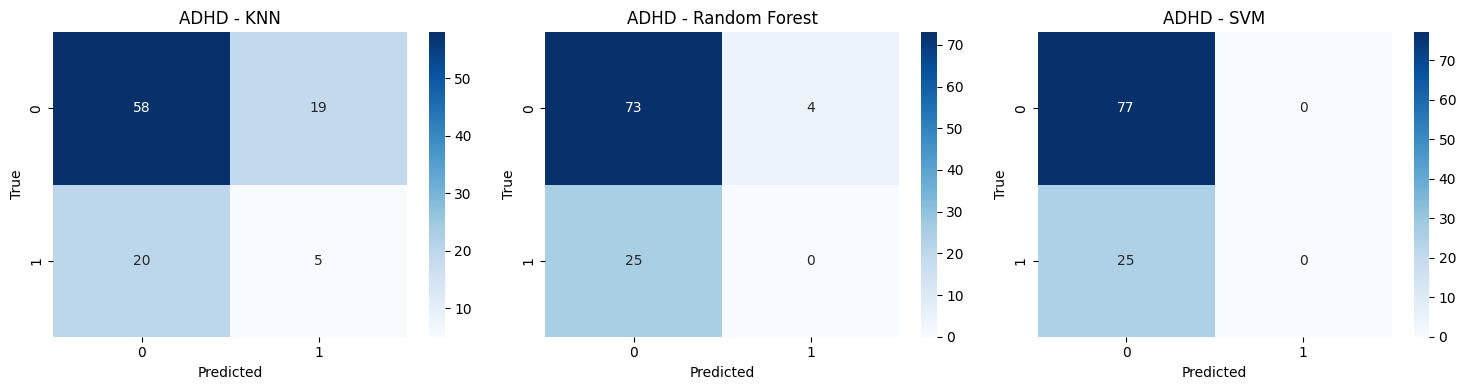

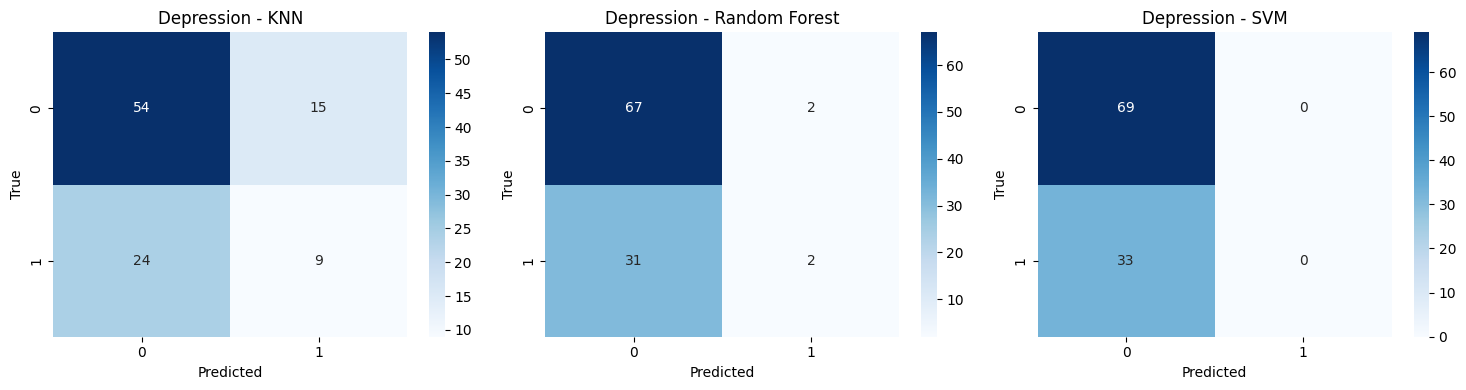

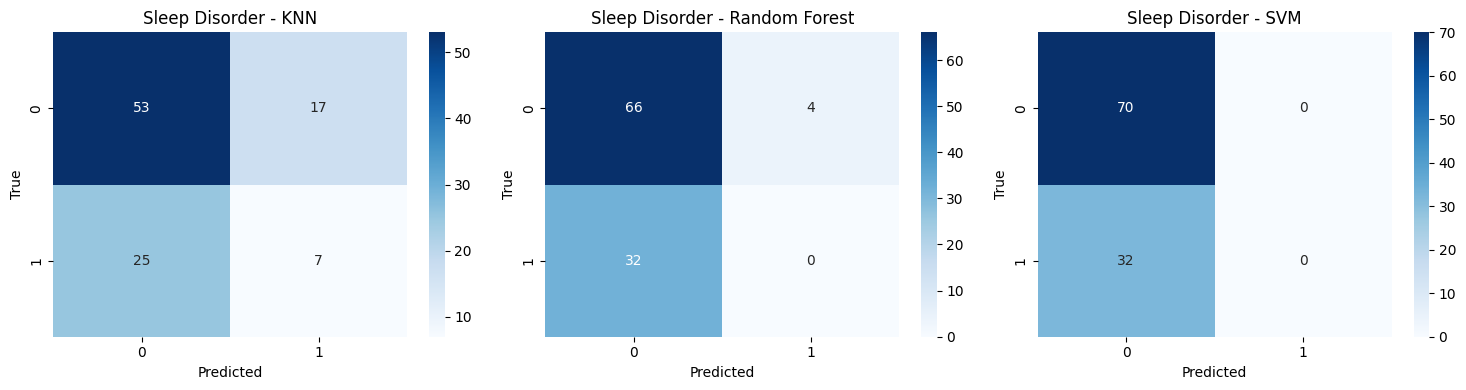

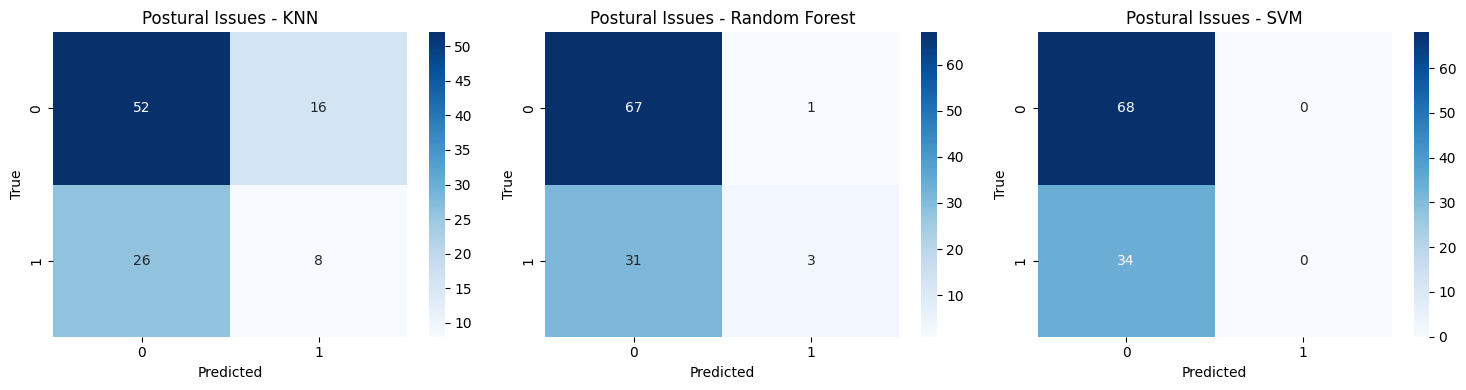

In [27]:
for label in y.columns:
    
    
    n_models = len(models)
    cols = 3
    rows = math.ceil(n_models / cols)
    
    plt.figure(figsize=(5 * cols, 4 * rows))  # Adjust figure size dynamically
    
    for i, (name, model) in enumerate(models.items(), 1):
        plt.subplot(rows, cols, i)
        preds = model.predict(X_test)
        cm = confusion_matrix(y_test[label], preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{label} - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')

    plt.tight_layout()
    plt.show()

# 6. Performance Evaluation

In [28]:
metrics_table = []

for label in y.columns:
    for name, model in models.items():
        preds = model.predict(X_test)
        prec = precision_score(y_test[label], preds)
        rec = recall_score(y_test[label], preds)
        f1 = f1_score(y_test[label], preds)
        acc = accuracy_score(y_test[label], preds)
        metrics_table.append([label, name, acc, prec, rec, f1])

df_metrics = pd.DataFrame(metrics_table, columns=['Target', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
df_metrics

,Target,Model,Accuracy,Precision,Recall,F1
0,ADHD,KNN,0.617647,0.208333,0.200000,0.204082
1,ADHD,Random Forest,0.715686,0.000000,0.000000,0.000000
2,ADHD,SVM,0.754902,0.000000,0.000000,0.000000
3,Depression,KNN,0.617647,0.375000,0.272727,0.315789
4,Depression,Random Forest,0.676471,0.500000,0.060606,0.108108
5,Depression,SVM,0.676471,0.000000,0.000000,0.000000
6,Sleep Disorder,KNN,0.588235,0.291667,0.218750,0.250000
7,Sleep Disorder,Random Forest,0.647059,0.000000,0.000000,0.000000
8,Sleep Disorder,SVM,0.686275,0.000000,0.000000,0.000000
9,Postural Issues,KNN,0.588235,0.333333,0.235294,0.275862


# 7. Model Comparisone

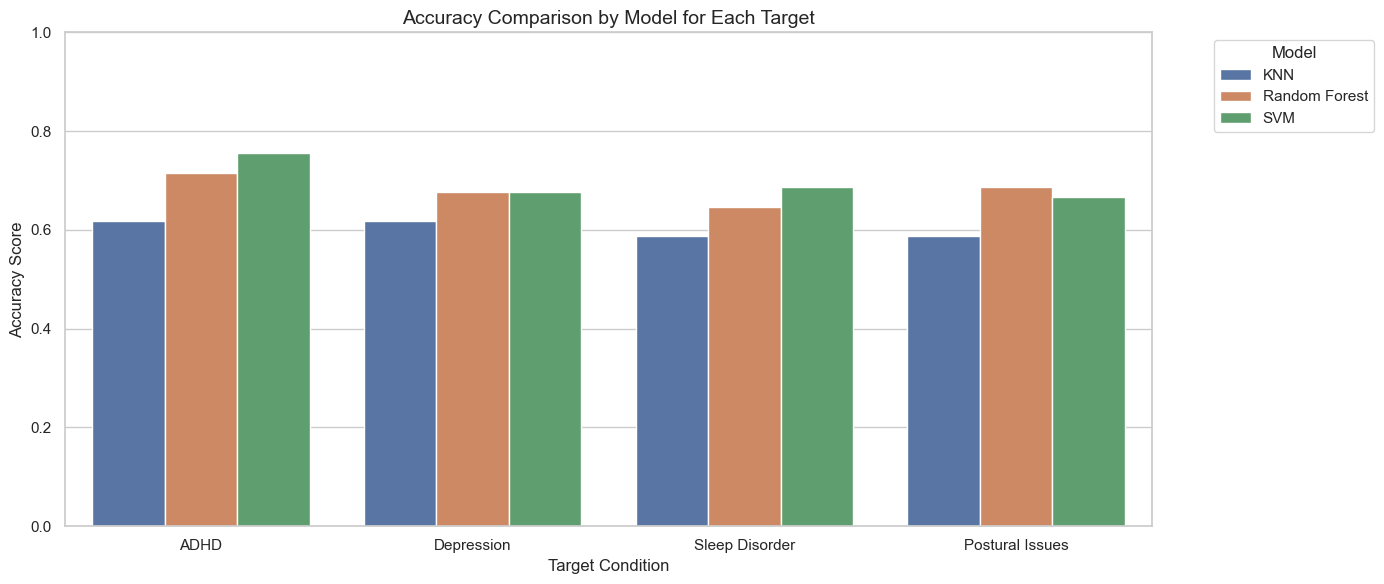

In [29]:
# Set style for better visuals
sns.set(style="whitegrid")

# Create the barplot for Accuracy
plt.figure(figsize=(14, 6))
sns.barplot(data=df_metrics, x='Target', y='Accuracy', hue='Model')

# Customize labels and legend
plt.title("Accuracy Comparison by Model for Each Target", fontsize=14)
plt.xlabel("Target Condition")
plt.ylabel("Accuracy Score")
plt.ylim(0, 1)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# 8. ROC Curve / AUC

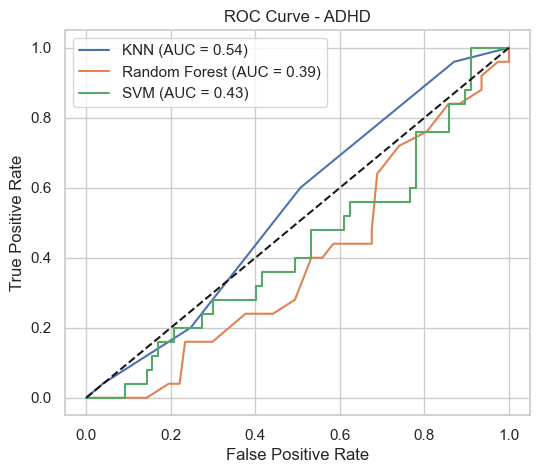

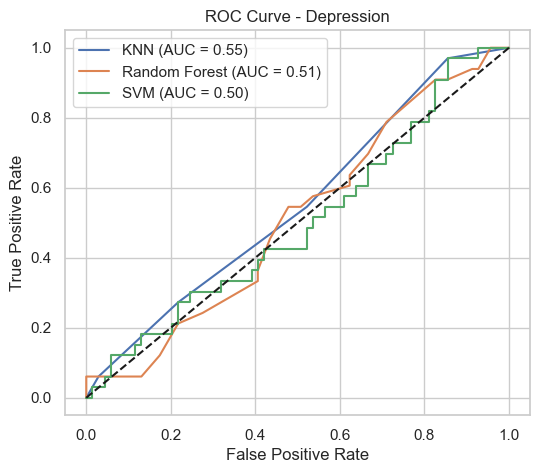

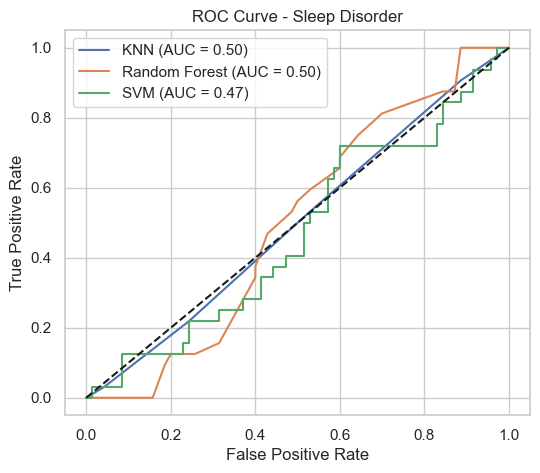

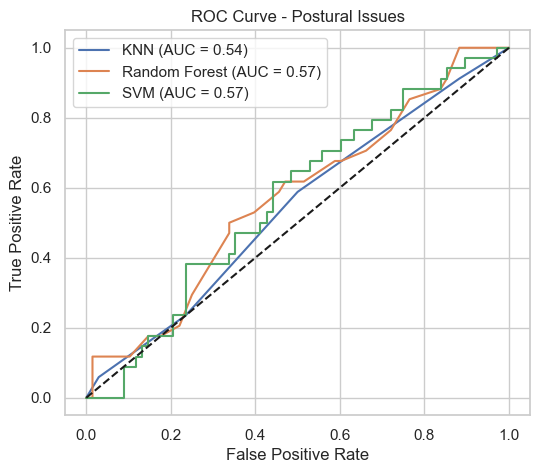

In [30]:
for label in y.columns:
    plt.figure(figsize=(6,5))
    for name, model in models.items():
        y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test[label], y_proba)
        auc_score = roc_auc_score(y_test[label], y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'ROC Curve - {label}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


# 9. Feature Importance (Random Forest) - Visualizetion

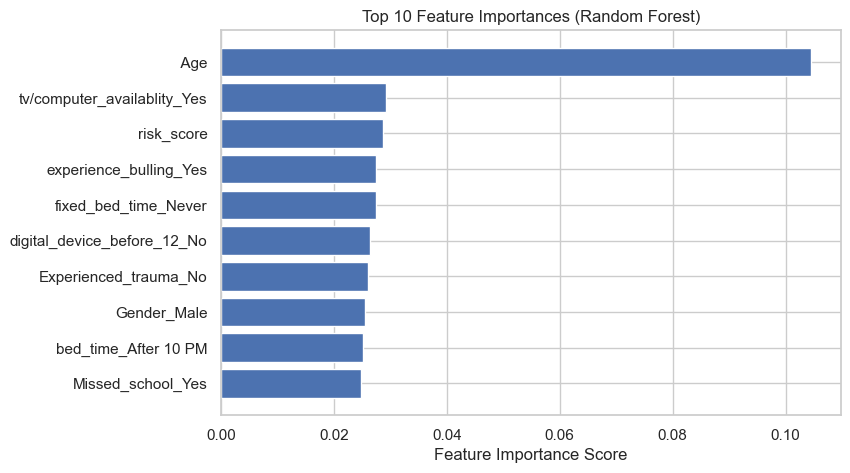

In [31]:
importances = models['Random Forest'].feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(8,5))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Feature Importance Score")
plt.show()


# 10. Ensemble Model with Bagging and Stacking

In [32]:
# Bagging
bag_model = BaggingClassifier(RandomForestClassifier(), n_estimators=10)
bag_model.fit(X_train, y_train['ADHD'])
bag_preds = bag_model.predict(X_test)
print("Bagging Accuracy:", accuracy_score(y_test['ADHD'], bag_preds))

# Stacking
stack_model = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier()),
        ('svm', SVC(probability=True))
    ],
    final_estimator=LogisticRegression()
)
stack_model.fit(X_train, y_train['ADHD'])
stack_preds = stack_model.predict(X_test)
print("Stacking Accuracy:", accuracy_score(y_test['ADHD'], stack_preds))


Bagging Accuracy: 0.7549019607843137
Stacking Accuracy: 0.7549019607843137
